/project/data/test/dhhw/MA_1.png
/project/data/test/dhhw/MA_4.png
/project/data/test/dhhw/MA_3.png
/project/data/test/dhhw/MA_2.png


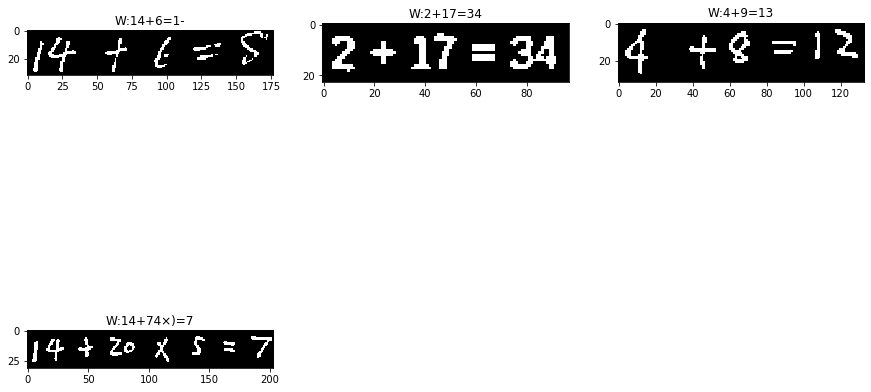

In [89]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from lib.crnn import CRNNClassify
from torch.autograd import Variable
import lib.dataset as dataset
import lib.utils as utils
import time
import importlib
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import lib.image_utils as img_utils
import lib.crnn as crnn
import math
importlib.reload(dataset)
importlib.reload(utils)
importlib.reload(img_utils)
importlib.reload(crnn)
plt.rcParams['figure.figsize'] = 15, 10

path = '/project'
# alpha = 'abcdefghij'
alpha = '0123456789+-÷×=)('
# alpha = '0123456789.'
# alpha = '√×'
thread_pre=15
need_dilate=False
converter = utils.strLabelConverter(alpha)
imgH=32
imgC=1
nh = 256


# net = crnn.CRNNClassify(imgH=imgH,nc=imgC,nh=nh, nclass=len(alpha)+1)
# net.load_state_dict(torch.load('{}/acrnn_best.pkh'.format(path),map_location=torch.device('cpu')))
# torch.save(net,'{}/acrnn_best.pkl'.format(path))
# net = torch.load('{}/save/scrnn_0.pkl'.format(path),map_location=torch.device('cpu'))
net = torch.load('{}/dhwcrnn_best.pkl'.format(path),map_location=torch.device('cpu'))
# 直接读灰度图
# image = cv2.imread('{}/data/images/1188_ChineseHWB.png'.format(path), cv2.IMREAD_GRAYSCALE)
# plt.imshow(image,'gray')
# plt.show()
# image = image[:,:,np.newaxis]
# print(net)
check_path = os.path.join(path,'data', 'test','dhhw')

check_files = []
for root, dirs, files in os.walk(check_path):
    for file in files:
        if file.endswith(".png"): # and file.find('√_2') != -1:
            check_files.append(os.path.join(root, file))

random.shuffle(check_files)
# print(check_files[1:20])
check_files = check_files[0:20]
rownum = int(len(check_files)/ 3) + 1
colnum = 3
plt.figure()
for idx, imgfile in enumerate(check_files):
    print(imgfile)
    
    image = cv2.imread(imgfile, cv2.IMREAD_COLOR)
    source_image = image.copy()
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    number = int(imgfile[imgfile.index('_') + 1:imgfile.index('.png')])

    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    if number >= 100:
        ret, image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV)
        
        percent = float(32) / image.shape[0]
        image = cv2.resize(image,(0,0), fx=percent, fy=percent, interpolation = cv2.INTER_AREA)
    else:
        percent = float(32) / image.shape[0]
        image = cv2.resize(image_gray,(0,0), fx=percent, fy=percent, interpolation = cv2.INTER_AREA)        
        x1,y1,x2,y2 = img_utils.detect_char_area(image.copy(),min_area=10)
        image = image[y1:y2,x1:x2]
        image = img_utils.convert_img_bin(image,thread_pre=thread_pre, need_dilate=need_dilate)
    crop_image = image.copy()
#     plt.imshow(image,'gray')
#     plt.show()
    
    

    image = image[:,:,np.newaxis]



    transformer = dataset.resizeLocalNormalize(imgH=32, keep_ratio=True)
    # origin_image = image.copy()
    image = transformer(image)
    image = image.unsqueeze(0)
#     print('transform image size -->{}'.format(image.size()))
    image = Variable(image)
    # image = image.cuda()


#     print(image.size())
    output = net(image)
    _,preds = output.max(2)
    preds = preds.squeeze(-2)
    preds = preds.view(-1)
#     print(preds)
    preds_size = Variable(torch.IntTensor([preds.size(0)]))
    words = converter.decode(preds.data, preds_size, raw=False)
    plt.subplot(rownum,colnum,idx+1)
    plt.title('W:{}'.format(words))
    plt.imshow(crop_image,'gray')
plt.show()
